## 1. Recursive Digital Filter Method (python)
 - Convert matlab code to python code

## Original matlab code (it does not work in colab)

In [ ]:
%Baseflow separation by Recursive Digital Filter (
clc
clear all
Q=xlsread('bf_separation');
a=0.998    %baseflow filter parameter%
R(1)=0;
B(1)=0;
for k=1:(length(Q)-1);
    R(k+1)=a.*R(k)+((1+a).*(Q(k+1)-Q(k)))/2;
    if R(k+1)<0;
        R(k+1)=0;
    end;
    if R(k+1)>Q(k+1);
       R(k+1)=Q(k+1);
    end;
     B(k+1)=Q(k+1)-R(k+1);
     dif(k+1)=Q(k+1)-B(k+1);
end;
plot(Q,'.-b'), grid on
xlabel('Time (hr)','FontName','times new roman','FontSize',12),ylabel('Water Level (mm)','FontName','times new roman','FontSize',12)
   title('Baseflow Separation')
hold on
plot(B,'.-r'),

In [4]:
# Moundt google drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [5]:
import pandas as pd
import numpy as np
import glob

In [6]:
path = '/gdrive/My Drive/data/digital_filter/'

In [7]:
Q = pd.read_csv(path + 'bf_separation.csv', header=None).to_numpy().flatten()
Q

array([85.74175, 85.64125, 85.55975, ..., 72.28825, 72.261  , 72.26875])

In [8]:
print(Q[0])
print(Q[1])

85.74175
85.64125


In [9]:
a=0.998    #%baseflow filter parameter%

In [10]:
R = np.zeros(len(Q))
B = np.zeros(len(Q))
dif = np.zeros(len(Q))

In [11]:
for k in range(0, len(Q)-1):
  # 다음단계의 R은 현재 R * a와 Q의 변화량의 1/2 * (1+a)를 의미함
  #R(k+1)=a.*R(k)+((1+a).*(Q(k+1)-Q(k)))/2;
  R[k+1] = a * R[k] + ((1+a)*(Q[k+1] - Q[k]))/2
  
  # R이 0보다 작다면, 0으로 처리
  # if R(k+1)<0;
  #   R(k+1)=0;
  if R[k+1] < 0:
    R[k+1] = 0
  
  # R이 Q보다 크면 Q로 처리
  # if R(k+1)>Q(k+1);
  #   R(k+1)=Q(k+1);
  if R[k+1] > Q[k+1]:
    R[k+1] = Q[k+1]

  # B는 Q - R
  #B(k+1)=Q(k+1)-R(k+1);
  B[k+1] = Q[k+1] - R[k+1]

  # dif == R
  #dif(k+1)=Q(k+1)-B(k+1);
  dif[k+1] = Q[k+1] - B[k+1]

In [12]:
df = pd.DataFrame({'Q': Q, 'B': B, 'R': R, 'dif': dif})
df

,Q,B,R,dif
0,85.74175,0.000000,0.000000,0.000000
1,85.64125,85.641250,0.000000,0.000000
2,85.55975,85.559750,0.000000,0.000000
3,85.46600,85.466000,0.000000,0.000000
4,85.44650,85.446500,0.000000,0.000000
...,...,...,...,...
6721,72.69300,49.891945,22.801055,22.801055
6722,72.43300,49.937287,22.495713,22.495713
6723,72.28825,49.982134,22.306116,22.306116
6724,72.26100,50.026719,22.234281,22.234281


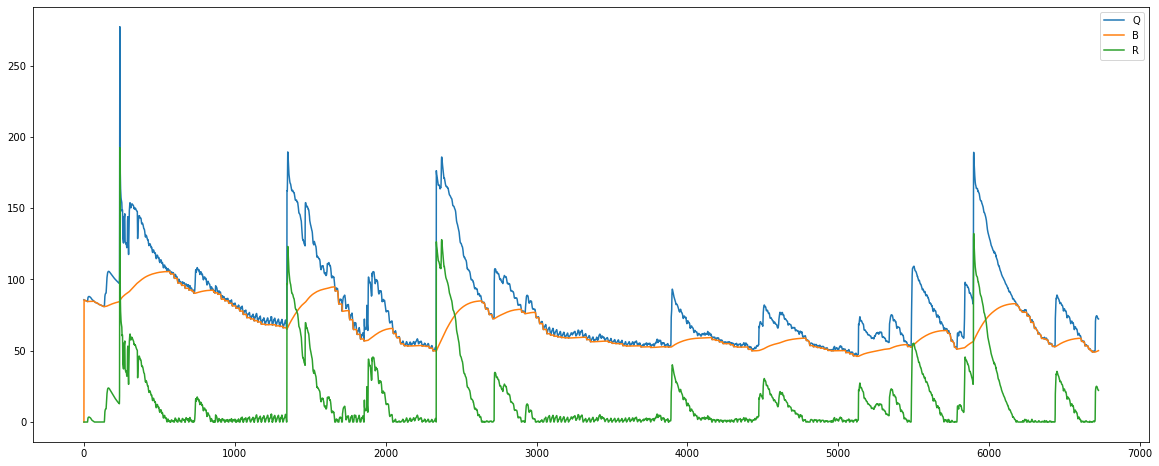

In [13]:
df[['Q', 'B', 'R']].plot(figsize=(20,8))

## [참고] 경험적 모드 분해(Empirical Mode Decompostion) : 신호처리 기반의 데이터 분리 기법으로, 적용해본 결과 수문 분리에 적용하는 것은 적합치 않은 것으로 판단됨, 딥러닝 기반의 다른 수문분리 기법이 있는지는 추가 조사 필요

In [2]:
import emd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [ ]:
# EMD tutorial:  https://emd.readthedocs.io/en/stable/emd_tutorials/01_sifting/emd_tutorial_01_sift_01_siftintro.html

(0.0, 600.0)

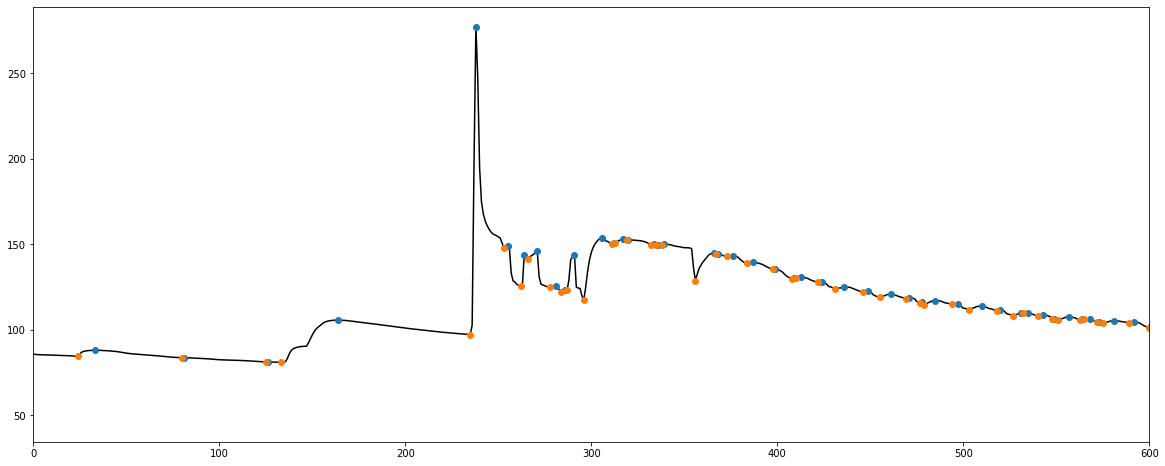

In [24]:
peak_locs, peak_mags = emd.sift.get_padded_extrema(Q, pad_width=0, mode='peaks')
trough_locs, trough_mags = emd.sift.get_padded_extrema(Q, pad_width=0, mode='troughs')

plt.figure(figsize=(20,8))
plt.plot(Q, 'k')
plt.plot(peak_locs, peak_mags, 'o')
plt.plot(trough_locs, trough_mags, 'o')
plt.xlim(0, 600)


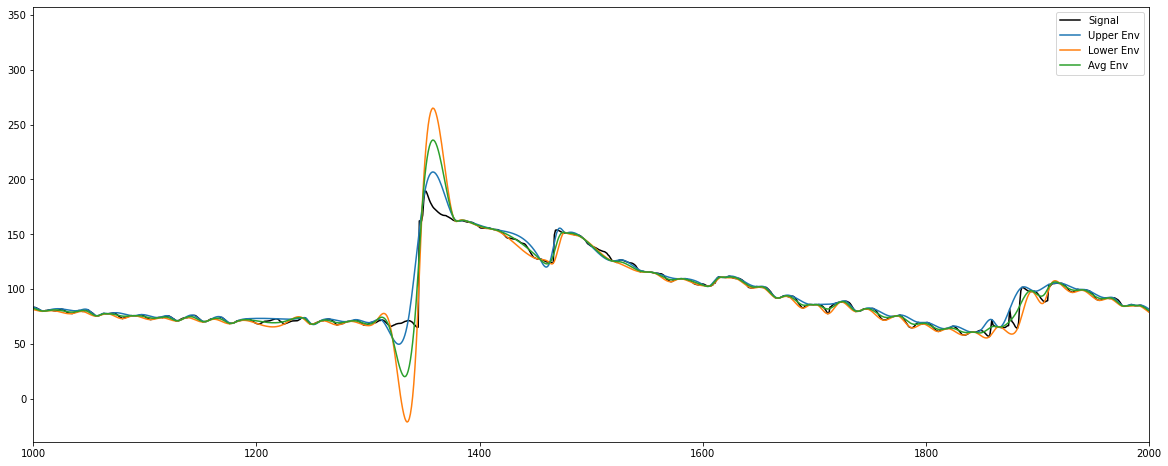

In [36]:
proto_imf = Q.copy()
# Compute upper and lower envelopes
upper_env = emd.sift.interp_envelope(proto_imf, mode='upper')
lower_env = emd.sift.interp_envelope(proto_imf, mode='lower')

# Compute average envelope
avg_env = (upper_env+lower_env) / 2

plt.figure(figsize=(20,8))
plt.plot(Q, 'k')
plt.plot(upper_env)
plt.plot(lower_env)
plt.plot(avg_env)
plt.xlim(1000, 2000)
plt.legend(['Signal', 'Upper Env', 'Lower Env', 'Avg Env'])

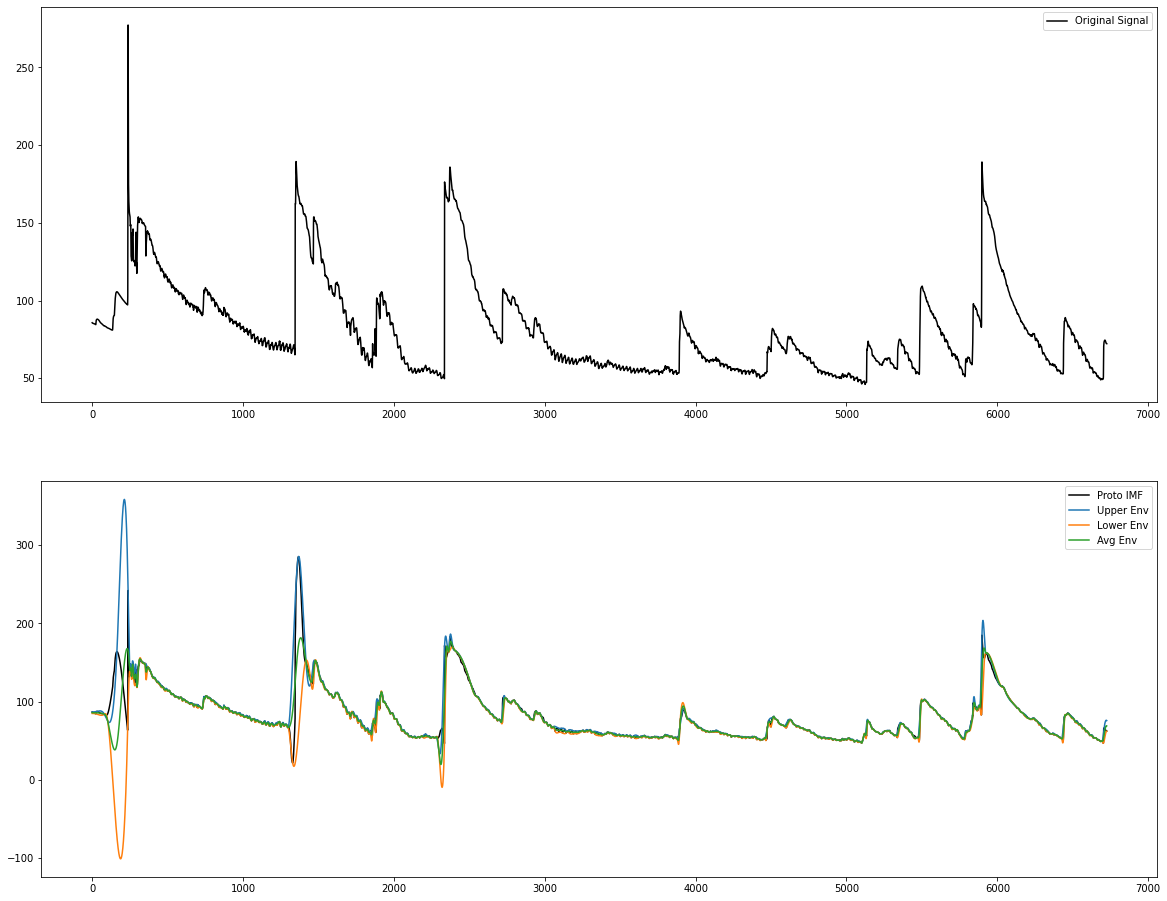

In [28]:
# Subtract slow dynamics from previous cell
proto_imf = Q - avg_env

# Compute upper and lower envelopes
upper_env = emd.sift.interp_envelope(proto_imf, mode='upper')
lower_env = emd.sift.interp_envelope(proto_imf, mode='lower')

# Compute average envelope
avg_env = (upper_env+lower_env) / 2

plt.figure(figsize=(20,16))
plt.subplot(211)
plt.plot(Q, 'k')
#plt.xlim(0, 600)
plt.legend(['Original Signal'])

plt.subplot(212)
plt.plot(proto_imf, 'k')
plt.plot(upper_env)
plt.plot(lower_env)
plt.plot(avg_env)
#plt.xlim(0, 600)
plt.legend(['Proto IMF', 'Upper Env', 'Lower Env', 'Avg Env'])

In [29]:
def my_get_next_imf(x, zoom=None, sd_thresh=0.1):

    proto_imf = x.copy()  # Take a copy of the input so we don't overwrite anything
    continue_sift = True  # Define a flag indicating whether we should continue sifting
    niters = 0            # An iteration counter

    if zoom is None:
        zoom = (0, x.shape[0])

    # Main loop - we don't know how many iterations we'll need so we use a ``while`` loop
    while continue_sift:
        niters += 1  # Increment the counter

        # Compute upper and lower envelopes
        upper_env = emd.sift.interp_envelope(proto_imf, mode='upper')
        lower_env = emd.sift.interp_envelope(proto_imf, mode='lower')

        # Compute average envelope
        avg_env = (upper_env+lower_env) / 2

        # Add a summary subplot
        plt.subplot(5, 1, niters)
        plt.plot(proto_imf[zoom[0]:zoom[1]], 'k')
        plt.plot(upper_env[zoom[0]:zoom[1]])
        plt.plot(lower_env[zoom[0]:zoom[1]])
        plt.plot(avg_env[zoom[0]:zoom[1]])

        # Should we stop sifting?
        stop, val = emd.sift.sd_stop(proto_imf-avg_env, proto_imf, sd=sd_thresh)

        # Remove envelope from proto IMF
        proto_imf = proto_imf - avg_env

        # and finally, stop if we're stopping
        if stop:
            continue_sift = False

    # Return extracted IMF
    return proto_imf

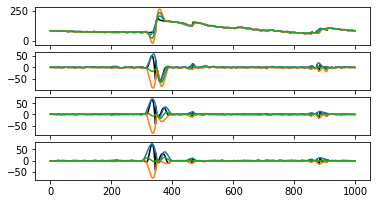

In [32]:
imf1 = my_get_next_imf(Q, zoom=(1000, 2000))


([], <a list of 0 Text major ticklabel objects>)

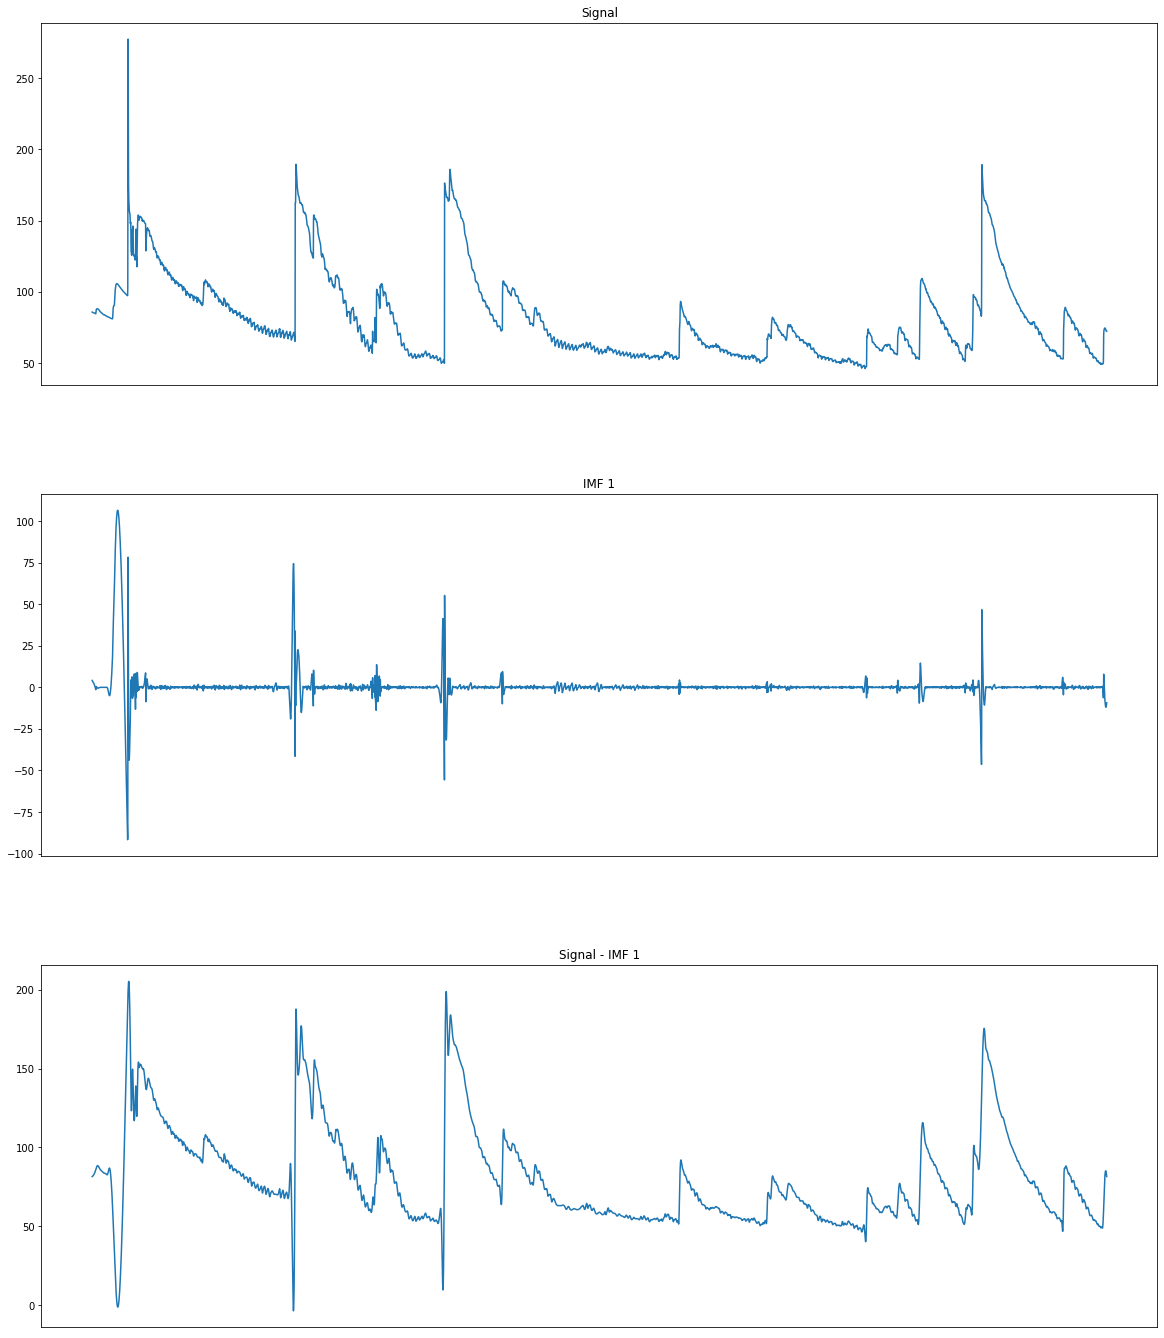

In [35]:
plt.figure(figsize=(20,24))
plt.subplots_adjust(hspace=0.3)

plt.subplot(311)
plt.plot(Q)
plt.title('Signal')
plt.xticks([])

plt.subplot(312)
plt.plot(imf1)
plt.title('IMF 1')
plt.xticks([])

plt.subplot(313)
plt.plot(Q - imf1)
plt.title('Signal - IMF 1')
plt.xticks([])